<a href="https://colab.research.google.com/github/DeemOne-personal/Python-lessons/blob/main/Copy_of_homework_2_poetry_generation_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.















---















In [122]:
from google.colab import drive
drive.mount('/content/drive')
#with open('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/HW2/sonnets.txt', 'r') as iofile:
with open('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/HW2/onegin.txt', 'r') as iofile:
    source_text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
names = source_text[TEXT_START : TEXT_END]
#assert len(names) == 2616
start_token = " "

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
import re
fullstr=''.join(line for line in names).lower()
fullstr = re.sub(r'[^\w]', ' ', fullstr)
fullstr=re.sub(' +', ' ', fullstr)
names=fullstr

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

max length = 1


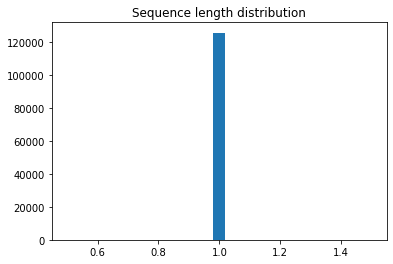

In [124]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title("Sequence length distribution")
plt.hist(list(map(len, names)), bins=25);

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [125]:
tokens = set()

for name in names:
    tokens.update(set(name))
tokens = sorted(list(tokens))  # <list of all unique characters in the dataset>

num_tokens = len(tokens)
print("num_tokens = ", num_tokens)

# <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {token: idx for idx, token in enumerate(tokens)}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"


num_tokens =  60


In [126]:
import numpy as np
def to_matrix(names, max_len=None, pad=token_to_id[" "], dtype="int32", batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""

    names=list([names])

    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, : len(line_ix)] = line_ix

    if not batch_first:  # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [127]:
# Example: cast 4 random names to matrices, pad with zeros
#print("\n".join(names[:5]))
#namesn=list([names])
print(to_matrix(names[:25]))


[[ 0 44 42 32 43 29 27  0 13  2  5  2 13  6  0 34 27  0 40 35 39  0 48 41
  31]]


In [128]:
import torch
import torch.nn.functional as F
from torch import nn

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """

    #def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
    def __init__(self, num_tokens=len(tokens), embedding_size=32, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)  # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h)  # YOUR CODE HERE

        h_next = torch.tanh(h_next)  # YOUR CODE HERE

        assert h_next.size() == h_prev.size()

        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next)  # YOUR CODE

        return h_next, logits

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [129]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()  # YOUR CODE HERE

**RNN LOOP**

In [130]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))

    return torch.stack(logprobs, dim=1)

In [131]:
#batch_ix = to_matrix(names[:5])
batch_ix = to_matrix(names[:200]) #increased for generating sentences
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) == batch_ix.shape + (num_tokens,)
logp_seq.shape

torch.Size([1, 200, 60])

Likelihood and gradients

In [132]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# .contiguous() method checks that tensor is stored in the memory correctly to
# get its view of desired shape.

loss = criterion(
    predictions_logp.contiguous().view(-1, num_tokens),
    actual_next_tokens.contiguous().view(-1),
)

In [133]:
loss.backward()

In [134]:
for w in char_rnn.parameters():
    assert (
        w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0
    ), "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (
        w.size(),
    )

**Loop**

In [135]:
import random
def getrndstr(srcstr, size=32):
  srcstr=srcstr.split() 
  wordcnt=len(names.split())
  wordrndnum=random.randrange(0, wordcnt-size)
  return ' '.join(line for line in srcstr[wordrndnum:wordrndnum+size])

In [145]:
batch_ix = to_matrix(getrndstr(names,MAX_LENGTH))
batch_ix

array([[29, 50, 32, ..., 45, 27, 37]], dtype=int32)

In [137]:
#from random import sample
import random
from IPython.display import clear_output

MAX_LENGTH=200

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

for i in range(1000):
    opt.zero_grad()
      
    #batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    #подкладываю рандомные слова
    batch_ix = to_matrix(getrndstr(names,MAX_LENGTH)) #new
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]  # YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]  # YOUR CODE HERE

    #     print(predictions_logp.shape, actual_next_tokens.shape)
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1),
    )
    # YOUR CODE HERE

    # train with backprop
    loss.backward()
    opt.step()

    # HISTORY MOVED TO SEPARATE SNIPPET
    history.append(loss.data.numpy())


**Generate samples**

In [138]:
def generate_sample(char_rnn, seed_phrase=" ", max_length=MAX_LENGTH, temperature=1.0):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

**Generate text**

In [ ]:
# An example of generated text. There is no function `generate_text` in the code above.
# print(generate_text(length=500, temperature=0.2))

In [139]:
for _ in range(3):
    print(generate_sample(char_rnn))

 летанись посешчим и стийгли и заздизит я чих скоха а грушенье ль и младите во и ворока удаший пралеть крдяки вочмою уснетоде и шейстиной и он дуяту всень ко приждаль онают и мадыу другом в мало у что
 праздонный и люокажию валоз ку за то дерусть xxii уж без xxуi пепся кикань боль на серутя и подсле буволеди да скозем добкий свении мори ты друг онегиле муочьдя навоялом и замя нет следи волидит xxix
 ах умелая него ро зоават за прове дувесь и мой холжку кровонать наш с так солвои поей завочиное рез мазскуx sачных заижить дадец он обошно я когдах конели я завои ни сторы но с никаняк пиестальные см


In [ ]:
for _ in range(3):
    print(generate_sample(char_rnn, seed_phrase=" Al"))

In [143]:
for _ in range(3):
    print(generate_sample(char_rnn, temperature=1))

 хопцру поклою причей у тамбись обеставинь нежильснива запетоватья облицы лика столко коть нам збец мне так звины гилое xi гость и не бенесь и вонный днешь краченья космел ез ни в таетый и по осъукv у
 обыи мумнаю со подвазь в проманирянья тот мерв пучак он сравны ились нел но как еещецный люду мольно нает сслизал он рочне и по двасьвы смаят ничей рев ончатим горо на вдево от страноя моечьстя души 
 пудавой она был чисто скеть отосник разреж деть оплозна струдя лещей на исладалду что ссвочей кехствинанских думный дароренют вотдаку содолочено вn разбор кучну групав деме битветь шорлала смелые шес


















































---



Plot the loss function (axis X: number of epochs, axis Y: loss function).

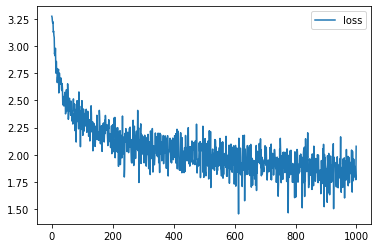

In [102]:
import matplotlib.pyplot as plt 
# Your plot code here
if (i + 1) % 100 == 0:
    clear_output(True)
    plt.plot(history, label="loss")
    plt.legend()
    plt.show()
#assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)